# Student Academic Performance Prediction

## Third Notebook: Predictive Modeling and Sensitivity Analysis
Following the extensive data preparation and feature engineering conducted in the previous phase, this notebook focuses on the core objective of the project: to develop a predictive model capable of estimating students’ final academic performance based on available academic and contextual information.

At this stage, we transition from data architecture to the construction and optimization of the predictive engine. To ensure the model is both robust and practically useful, we implement a sensitivity analysis strategy, testing the predictive performance across different feature subsets.

We will evaluate a diverse range of regression architectures (from interpretable linear frameworks to complex non-linear models) to identify the most effective engine for capturing student performance patterns. This multi-class approach allows us to test how different mathematical logics respond to our engineered features and latent student profiles.

Each model will be rigorously assessed using a multi-metric approach across both the **Mathematics** and **Portuguese** datasets. By comparing performance across our sensitivity scenarios, we aim to determine the optimal balance between model complexity and interpretability for early academic risk identification.

**Author:** J-F Jutras  
**Date:** January 2026  
**Dataset:** Student Performance — UCI / Kaggle (Portuguese Secondary Education)

## 3.1-Data Loading

In [1]:
import pickle
import pandas as pd
import numpy as np
import os
import warnings
import sys

warnings.filterwarnings('ignore')

#Path for the pre-processed modeling bundle
bundle_path = "/kaggle/input/studentperformancemodeling/student_performance_modeling_bundle.pkl"

with open(bundle_path, 'rb') as f:
    modeling_bundle = pickle.load(f)

#Extract processed DataFrames
train_port = modeling_bundle["data"]["portuguese"]["train"]
test_port = modeling_bundle["data"]["portuguese"]["test"]
train_math = modeling_bundle["data"]["math"]["train"]
test_math = modeling_bundle["data"]["math"]["test"]

#Extract metadata
scalers = modeling_bundle["metadata"].get("scalers")
base_features = modeling_bundle["metadata"].get("features_base")
sensitivity_features = modeling_bundle["metadata"].get("features_sensitivity")
target = modeling_bundle["metadata"].get("target")

#Load raw datasets for FAMD
dataset_dir = "/kaggle/input/acamedicperfomance"
df_port_raw = pd.read_csv(os.path.join(dataset_dir, "student_language.csv"), sep=";")
df_math_raw = pd.read_csv(os.path.join(dataset_dir, "student_math.csv"), sep=";")

#Clone utilities repository
!rm -rf /kaggle/working/jfj-utils
!git clone https://github.com/jfjutras07/jfj-utils.git
sys.path.append("/kaggle/working/jfj-utils")

#Quick Data Verification
print(f"--- Data Loading Summary ---")
print(f"Processed Portuguese: {train_port.shape[0]} rows")
print(f"Processed Mathematics: {train_math.shape[0]} rows")
print(f"Raw Data Status: Loaded (Port: {df_port_raw.shape[0]} rows, Math: {df_math_raw.shape[0]} rows)")
print(f"Available Metadata: {list(modeling_bundle['metadata'].keys())}")

Cloning into 'jfj-utils'...
remote: Enumerating objects: 2121, done.
remote: Counting objects: 100% (196/196), done.
remote: Compressing objects: 100% (174/174), done.
remote: Total 2121 (delta 132), reused 21 (delta 21), pack-reused 1925 (from 3)
Receiving objects: 100% (2121/2121), 705.78 KiB | 16.04 MiB/s, done.
Resolving deltas: 100% (1364/1364), done.
--- Data Loading Summary ---
Processed Portuguese: 519 rows
Processed Mathematics: 316 rows
Raw Data Status: Loaded (Port: 649 rows, Math: 395 rows)
Available Metadata: ['pca_models', 'scaler', 'features_early', 'features_full']


### Column Description


| Variable | Description | Variable | Description |
|---------|-------------|---------|-------------|
| school | Student's school (GP or MS) | sex | Student's sex (F or M) |
| age | Student's age (15–22) | address | Home address type (Urban or Rural) |
| famsize | Family size (≤3 or >3) | Pstatus | Parents' cohabitation status |
| Medu | Mother's education level (0–4) | Fedu | Father's education level (0–4) |
| Mjob | Mother's occupation | Fjob | Father's occupation |
| reason | Reason for choosing the school | guardian | Student's guardian |
| traveltime | Home-to-school travel time (1–4) | studytime | Weekly study time (1–4) |
| failures | Number of past class failures | schoolsup | Extra educational support |
| famsup | Family educational support | paid | Extra paid classes (subject-specific) |
| activities | Extra-curricular activities | nursery | Attended nursery school |
| higher | Intention to pursue higher education | internet | Internet access at home |
| romantic | In a romantic relationship | famrel | Family relationship quality (1–5) |
| freetime | Free time after school (1–5) | goout | Going out with friends (1–5) |
| Dalc | Workday alcohol consumption (1–5) | Walc | Weekend alcohol consumption (1–5) |
| health | Current health status (1–5) | absences | Number of school absences |
| G1 | First period grade (0–20) | G2 | Second period grade (0–20) |
| G3 | Final grade (0–20) |  |  |


## 3.2-Sensitivity Analysis Strategy

To rigorously evaluate the predictive power of our features, we implement a Sensitivity Analysis strategy. By training our models on different subsets of variables, we can isolate the impact of academic history (G1/G2) versus social and demographic context.

| Stage | Phase Name                          | Objective |
|-------|-------------------------------------|-----------|
| 1     | Establishing Performance Baselines  | Define the initial predictive threshold using raw academic and socio-demographic data. This phase focuses on refining the original variables by isolating stable predictors and filtering out environmental noise to improve model generalization. |
| 2     | Feature Intelligence & Momentum     | Evaluate the added value of composite indices and academic trajectory. This stage tests whether a student’s "velocity" (their progress and evolution between grading periods) is more informative than static academic standing. |
| 3     | Practical Optimization & Efficiency| Identify the core nucleus of the most influential variables to design a streamlined model. This phase determines the minimum information required for schools to detect academic risk with maximum precision and minimal data collection effort. |


## 3.3-Establishing Performance Baselines

We use a suite of regularized models because they are specifically designed to handle the high multicollinearity in this dataset, helping us filter out redundant variables and find the most stable mathematical baseline. By adding a Random Forest at this early stage, we create a direct comparison between a "straight-line" logic and a more complex "interaction" logic. This tells us immediately if academic performance is driven by simple, direct factors or if it depends on hidden combinations of traits that only a non-linear model can detect.

### Baseline Without G1/G2

This baseline scenario establishes the "predictive floor" by relying solely on entry-level student profiles, allowing us to measure how much academic risk can be identified before a single grade is even recorded.

In [2]:
#Portuguese dataset

#Target variable
outcome = 'G3'

#Scenario: Baseline
base_features_static = [
    #Original numerical/binary
    'school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 
    'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 
    'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 
    'higher', 'internet', 'romantic', 'famrel', 'freetime', 
    'goout', 'Dalc', 'Walc', 'health', 
    
    #The new version of absences
    'absences_log', 
    
    #One-Hot Encoded variables
    'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher',
    'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher',
    'guardian_father', 'guardian_mother', 'guardian_other',
    'reason_course', 'reason_home', 'reason_other', 'reason_reputation'
]

from modeling.regularization import compare_regularized_models
compare_regularized_models(train_port, test_port, outcome = outcome, predictors = base_features_static)

Starting Regularized Models Comparison...
Predictors: 43 | CV Folds: 5
-----------------------------------
--- Lasso Regression Summary ---
Best Alpha: 0.02452
R2 Score (Test): 0.2248 | Features: 29/43
-----------------------------------
--- Ridge Regression Summary ---
Best Alpha: 141.74742
R2 Score (Test): 0.2449
-----------------------------------
--- ElasticNet Regression Summary ---
Best Alpha: 0.14028 | Best L1: 0.10
R2 Score (Test): 0.2407 | Features: 34/43
-----------------------------------

--- Final Comparison Summary ---
                  R2       MAE      RMSE
Ridge       0.244888  0.614324  0.836405
ElasticNet  0.240653  0.619853  0.838748
Lasso       0.224817  0.630951  0.847448
-----------------------------------

Model Champion: Ridge
Top 5 Coefficients for Ridge (Sorted by impact):


,Feature,Coefficient
10,failures,-0.213154
0,school,0.152644
16,higher,0.137775
11,schoolsup,-0.107230
9,studytime,0.089543


Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('model',
                 RidgeCV(alphas=array([1.00000000e-03, 1.14975700e-03, 1.32194115e-03, 1.51991108e-03,
       1.74752840e-03, 2.00923300e-03, 2.31012970e-03, 2.65608778e-03,
       3.05385551e-03, 3.51119173e-03, 4.03701726e-03, 4.64158883e-03,
       5.33669923e-03, 6.13590727e-03, 7.05480231e-03, 8.111...
       4.03701726e+01, 4.64158883e+01, 5.33669923e+01, 6.13590727e+01,
       7.05480231e+01, 8.11130831e+01, 9.32603347e+01, 1.07226722e+02,
       1.23284674e+02, 1.41747416e+02, 1.62975083e+02, 1.87381742e+02,
       2.15443469e+02, 2.47707636e+02, 2.84803587e+02, 3.27454916e+02,
       3.76493581e+02, 4.32876128e+02, 4.97702356e+02, 5.72236766e+02,
       6.57933225e+02, 7.56463328e+02, 8.69749003e+02, 1.00000000e+03]),
                         cv=5))])

To ensure clarity and computational efficiency, here the full modeling workflow is explicitly displayed for the Portuguese dataset using Regularized Models. For all other baseline evaluations, results are synthesized in the table below to provide a direct comparative view of how different architectures handle socio-demographic predictors.

**Summary - Baseline Without G1 and G2**

| Dataset       | Model         | R² Score | MAE    | Top 5 Predictors (By Impact) |
|---------------|---------------|----------|--------|-------------------------------|
| Portuguese    | Ridge         | 0.2449   | 0.6143 | failures, school, higher, schoolsup, studytime |
| Portuguese    | ElasticNet    | 0.2407   | 0.6199 | school, higher, failures, studytime, Fedu |
| Portuguese    | Lasso         | 0.2248   | 0.6310 | school, higher, studytime, Fedu, reason_reputation |
| Portuguese    | Random Forest | 0.1893   | 0.6417 | failures, school, absences_log, Dalc, higher |
| Mathematics   | Ridge         | 0.1323   | 0.7458 | failures, absences_log, sex, higher, studytime |
| Mathematics   | ElasticNet    | 0.1152   | 0.7560 | failures, higher, studytime, Medu, Fedu |
| Mathematics   | Lasso         | 0.0883   | 0.7641 | failures, higher, Medu, schoolsup, age |
| Mathematics   | Random Forest | 0.2730   | 0.6749 | absences_log, failures, health, goout, age |


**Subject Divergence:** A significant performance split emerges between subjects; the Portuguese dataset is best served by a linear **Ridge** regression ($R^2 = 0.2449$), while the Mathematics dataset requires the non-linear complexity of a **Random Forest** to reach its peak accuracy ($R^2 = 0.2730$).

**Linear vs. Non-Linear Logic:** In Portuguese, regularized models outperform Random Forest, suggesting that linguistic performance is driven by direct, additive factors. Conversely, the "linearity gap" in Mathematics indicates that success depends on more complex interactions between behavioral traits and student history that linear models fail to capture.

**Core Predictors:** Across all models, **past failures** and **ambition for higher education** consistently appear as the strongest predictors. However, Mathematics shows a much higher sensitivity to **absences** and **health** compared to the Portuguese dataset.

**Regularization Impact:** **Ridge regression** proves to be the most stable linear approach, successfully managing the high multicollinearity of the dataset better than Lasso or ElasticNet, which appear to drop potentially useful contextual variables too aggressively at this stage.

### Baseline Including G1/G2

In [3]:
#Portuguese dataset

#Scenario: Baseline + G1 and G2
full_features_static = [
    #Original numerical/binary
    'school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 
    'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 
    'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 
    'higher', 'internet', 'romantic', 'famrel', 'freetime', 
    'goout', 'Dalc', 'Walc', 'health', 
    
    #The new version of absences
    'absences_log', 
    
    #One-Hot Encoded variables
    'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher',
    'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher',
    'guardian_father', 'guardian_mother', 'guardian_other',
    'reason_course', 'reason_home', 'reason_other', 'reason_reputation',

    #G1-G2
    'G1', 'G2'
]

compare_regularized_models(train_port, test_port, outcome = outcome, predictors = full_features_static)

Starting Regularized Models Comparison...
Predictors: 45 | CV Folds: 5
-----------------------------------
--- Lasso Regression Summary ---
Best Alpha: 0.02113
R2 Score (Test): 0.8643 | Features: 17/45
-----------------------------------
--- Ridge Regression Summary ---
Best Alpha: 10.00000
R2 Score (Test): 0.8545
-----------------------------------
--- ElasticNet Regression Summary ---
Best Alpha: 0.03019 | Best L1: 0.70
R2 Score (Test): 0.8636 | Features: 17/45
-----------------------------------

--- Final Comparison Summary ---
                  R2       MAE      RMSE
Lasso       0.864267  0.223183  0.354612
ElasticNet  0.863598  0.222400  0.355485
Ridge       0.854514  0.230606  0.367131
-----------------------------------

Model Champion: Lasso
Top 5 Coefficients for Lasso (Sorted by impact):


,Feature,Coefficient
44,G2,0.755933
43,G1,0.142489
25,absences_log,0.025847
41,reason_other,-0.023855
0,school,0.023551


Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('model', LassoCV(cv=5, random_state=42))])

**Summary - Baseline Including G1 and G2**

| Dataset       | Model         | R² Score | MAE    | Top 5 Predictors (By Impact) |
|---------------|---------------|----------|--------|-------------------------------|
| Portuguese    | Lasso         | 0.8643   | 0.2232 | G2, G1, absences_log, reason_other, school |
| Portuguese    | ElasticNet    | 0.8636   | 0.2224 | G2, G1, absences_log, reason_other, school |
| Portuguese    | Ridge         | 0.8545   | 0.2306 | G2, G1, absences_log, school, failures |
| Portuguese    | Random Forest | 0.8486   | 0.2236 | G2, absences_log, G1, age, Dalc |
| Mathematics   | Random Forest | 0.8519   | 0.2382 | G2, absences_log, reason_home, age, G1 |
| Mathematics   | Lasso         | 0.7956   | 0.3001 | G2, absences_log, G1, famrel, failures |
| Mathematics   | ElasticNet    | 0.7956   | 0.3001 | G2, absences_log, G1, famrel, failures |
| Mathematics   | Ridge         | 0.7702   | 0.3450 | G2, G1, absences_log, famrel, failures |


**G2 Dominance**: The inclusion of mid-year grades creates a massive performance leap, with R² scores exceeding 0.85. In all models, G2 is the dominant predictor, confirming that academic momentum outweighs other factors once available.

**Contextual Resilience**: Despite the predictive power of grades, absences_log remains a top 3 predictor for both subjects. This proves that even with identical grades, attendance provides a crucial independent signal regarding a student's final stability.

**Subject Specificity**: Portuguese remains better served by linear regularization (Lasso/ElasticNet), while Mathematics still benefits from the non-linear structure of Random Forest, which better handles result volatility in this discipline.

**Feature Sparsity**: Lasso and ElasticNet models reduced the set to approximately 17 key variables, signaling that much of the initial socio-demographic noise is absorbed by intermediate academic performance.

## 3.4-Baseline Optimization

To refine the model, we apply an **empirical pruning strategy**. Instead of keeping all predictors, we filter the feature set based on the previous results:

* **Elimination of "Weak Learners"**: Variables like `Pstatus`, `famsize`, and several specific `Mjob`/`Fjob` categories were removed due to their consistently near-zero coefficients in Lasso and Ridge regressions.
* **Simplification**: We removed redundant socio-behavioral indicators (e.g., `nursery`, `famsup`) that added complexity without contributing to the R² score.

The goal is to determine if this leaner, more interpretable set can achieve similar (or better) predictive performance than the full set by reducing the risk of overfitting on noise.

### Optimized Baseline Without G1/G2

In [4]:
#Portuguese dataset

#Scenario: Optimized Baseline
base_opt_features = [
    'school', 'sex', 'age', 'address', 'Medu', 'Fedu', 
    'studytime', 'failures', 'schoolsup', 'higher', 
    'romantic', 'famrel', 'freetime', 'goout', 
    'Dalc', 'Walc', 'health', 'absences_log',
    'Mjob_teacher', 'Mjob_services', 'Fjob_teacher', 
    'reason_reputation', 'guardian_other'
]

compare_regularized_models(train_port, test_port, outcome = outcome, predictors = base_opt_features)

Starting Regularized Models Comparison...
Predictors: 23 | CV Folds: 5
-----------------------------------
--- Lasso Regression Summary ---
Best Alpha: 0.02132
R2 Score (Test): 0.2038 | Features: 19/23
-----------------------------------
--- Ridge Regression Summary ---
Best Alpha: 107.22672
R2 Score (Test): 0.2199
-----------------------------------
--- ElasticNet Regression Summary ---
Best Alpha: 0.12201 | Best L1: 0.10
R2 Score (Test): 0.2142 | Features: 21/23
-----------------------------------

--- Final Comparison Summary ---
                  R2       MAE      RMSE
Ridge       0.219907  0.632892  0.850128
ElasticNet  0.214187  0.635905  0.853239
Lasso       0.203786  0.641560  0.858867
-----------------------------------

Model Champion: Ridge
Top 5 Coefficients for Ridge (Sorted by impact):


,Feature,Coefficient
7,failures,-0.229815
0,school,0.177879
9,higher,0.144907
8,schoolsup,-0.119183
6,studytime,0.088971


Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('model',
                 RidgeCV(alphas=array([1.00000000e-03, 1.14975700e-03, 1.32194115e-03, 1.51991108e-03,
       1.74752840e-03, 2.00923300e-03, 2.31012970e-03, 2.65608778e-03,
       3.05385551e-03, 3.51119173e-03, 4.03701726e-03, 4.64158883e-03,
       5.33669923e-03, 6.13590727e-03, 7.05480231e-03, 8.111...
       4.03701726e+01, 4.64158883e+01, 5.33669923e+01, 6.13590727e+01,
       7.05480231e+01, 8.11130831e+01, 9.32603347e+01, 1.07226722e+02,
       1.23284674e+02, 1.41747416e+02, 1.62975083e+02, 1.87381742e+02,
       2.15443469e+02, 2.47707636e+02, 2.84803587e+02, 3.27454916e+02,
       3.76493581e+02, 4.32876128e+02, 4.97702356e+02, 5.72236766e+02,
       6.57933225e+02, 7.56463328e+02, 8.69749003e+02, 1.00000000e+03]),
                         cv=5))])

**Summary - Optimized Baseline Without G1 and G2**

| Dataset       | Model         | R² Score | MAE    | Top 5 Predictors (By Impact) |
|---------------|---------------|----------|--------|-------------------------------|
| Portuguese    | Ridge         | 0.2199   | 0.6329 | failures, school, higher, schoolsup, studytime |
| Portuguese    | ElasticNet    | 0.2142   | 0.6359 | failures, school, higher, schoolsup, studytime |
| Portuguese    | Lasso         | 0.2038   | 0.6416 | failures, school, higher, schoolsup, studytime |
| Portuguese    | Random Forest | 0.1769   | 0.6530 | failures, school, absences_log, Dalc, higher |
| Mathematics   | Random Forest | 0.2347   | 0.6951 | absences_log, failures, health, goout, age |
| Mathematics   | Ridge         | 0.1711   | 0.7178 | failures, absences_log, sex, Medu, studytime |
| Mathematics   | ElasticNet    | 0.1454   | 0.7355 | failures, absences_log, Medu, studytime, higher |
| Mathematics   | Lasso         | 0.1338   | 0.7425 | failures, absences_log, Medu, sex, higher |


### Optimized Baseline Including G1/G2

**Summary - Optimized Baseline Including G1 and G2**

| Dataset       | Model         | R² Score | MAE    | Top 5 Predictors (By Impact) |
|---------------|---------------|----------|--------|-------------------------------|
| Portuguese    | Lasso         | 0.8648   | 0.2225 | G2, G1, absences_log, school, failures |
| Portuguese    | ElasticNet    | 0.8646   | 0.2224 | G2, G1, absences_log, school, failures |
| Portuguese    | Ridge         | 0.8565   | 0.2269 | G2, G1, absences_log, school, failures |
| Portuguese    | Random Forest | 0.8502   | 0.2181 | G2, absences_log, G1, age, school |
| Mathematics   | Random Forest | 0.8276   | 0.2463 | G2, absences_log, age, health, famrel |
| Mathematics   | Lasso         | 0.7969   | 0.2959 | G2, absences_log, G1, famrel, failures |
| Mathematics   | ElasticNet    | 0.7969   | 0.2959 | G2, absences_log, G1, famrel, failures |
| Mathematics   | Ridge         | 0.7816   | 0.3315 | G2, absences_log, G1, famrel, failures |


**Performance Paradox**: Without mid-year grades, feature pruning leads to a slight decrease in R² (from ~0.25 to ~0.22). This indicates that while socio-demographic variables are individually "weak," they collectively carry a subtle signal that helps profile a student before the first exams.

**Noise Filtration**: With mid-year grades, pruning actually stabilizes or slightly improves performance (e.g., Portuguese Lasso rising to 0.8648). This proves that G1/G2 already capture the relevant signal; the removed variables were essentially "noise" that risked causing overfitting.

**Predictive Concentration**: The stability of the **Top 5 Predictors** across both the full and pruned versions confirms the robustness of your selection. Regardless of model complexity, **failures**, **absences**, and **ambition (higher)** remain the pillars of prediction, validating the quality of your initial data cleaning.

**Subject Specificity**: Mathematics appears more sensitive to pruning than Portuguese, showing a more noticeable performance drop. This suggests that success in Math depends on a broader, less linear ecosystem of factors, making simplification more challenging for this specific subject.

## 3.5-Feature Intelligence and Momentum

Based on the consistent performance patterns observed across all baseline scenarios, we will adopt a differentiated modeling strategy for the remainder of the project:

* **Portuguese**: Given that **Ridge** and **Lasso** consistently outperformed non-linear models, we will prioritize regularized linear regressions. The relationship between socio-demographic factors and language performance appears primarily additive and stable.
* **Mathematics**: **Random Forest** consistently proved superior for the Mathematics dataset. This indicates that mathematical success is influenced by complex, non-linear interactions between variables (e.g., the combined effect of health, absences, and age) that linear models fail to capture.

By specializing the model choice for each subject, we optimize for the specific underlying logic of the two different academic disciplines.

### Engineered Scenario - Portuguese and Mathematics - Without G1/G2

In [5]:
#Portuguese Dataset

#Scenario: Engineered_P
eng_features = [
    #Original numerical/binary
    'school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 
    'traveltime', 'studytime', 'failures', 
    'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 
    'higher', 'internet', 'romantic', 'famrel', 'freetime', 
    'goout', 'health', 
    
    #The new version of absences
    'absences_log', 
    
    #One-Hot Encoded variables
    'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher',
    'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher',
    'guardian_father', 'guardian_mother', 'guardian_other',
    'reason_course', 'reason_home', 'reason_other', 'reason_reputation',

     #Composite Replacements
    'Parental_Edu_Level', #Aggregates Medu & Fedu
    'Alcohol_Index',      #Aggregates Dalc & Walc

]

compare_regularized_models(train_port, test_port, outcome = outcome, predictors = eng_features)

Starting Regularized Models Comparison...
Predictors: 41 | CV Folds: 5
-----------------------------------
--- Lasso Regression Summary ---
Best Alpha: 0.03995
R2 Score (Test): 0.2176 | Features: 18/41
-----------------------------------
--- Ridge Regression Summary ---
Best Alpha: 141.74742
R2 Score (Test): 0.2497
-----------------------------------
--- ElasticNet Regression Summary ---
Best Alpha: 0.15042 | Best L1: 0.10
R2 Score (Test): 0.2456 | Features: 32/41
-----------------------------------

--- Final Comparison Summary ---
                  R2       MAE      RMSE
Ridge       0.249678  0.612262  0.833748
ElasticNet  0.245617  0.617260  0.836001
Lasso       0.217650  0.632476  0.851357
-----------------------------------

Model Champion: Ridge
Top 5 Coefficients for Ridge (Sorted by impact):


,Feature,Coefficient
8,failures,-0.214302
0,school,0.154196
14,higher,0.139156
9,schoolsup,-0.108518
7,studytime,0.089236


Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('model',
                 RidgeCV(alphas=array([1.00000000e-03, 1.14975700e-03, 1.32194115e-03, 1.51991108e-03,
       1.74752840e-03, 2.00923300e-03, 2.31012970e-03, 2.65608778e-03,
       3.05385551e-03, 3.51119173e-03, 4.03701726e-03, 4.64158883e-03,
       5.33669923e-03, 6.13590727e-03, 7.05480231e-03, 8.111...
       4.03701726e+01, 4.64158883e+01, 5.33669923e+01, 6.13590727e+01,
       7.05480231e+01, 8.11130831e+01, 9.32603347e+01, 1.07226722e+02,
       1.23284674e+02, 1.41747416e+02, 1.62975083e+02, 1.87381742e+02,
       2.15443469e+02, 2.47707636e+02, 2.84803587e+02, 3.27454916e+02,
       3.76493581e+02, 4.32876128e+02, 4.97702356e+02, 5.72236766e+02,
       6.57933225e+02, 7.56463328e+02, 8.69749003e+02, 1.00000000e+03]),
                         cv=5))])

**Summary - Engineered Scenario - Portuguese and Mathematics - Without G1 and G2**

| Dataset     | Model         | R² Score | MAE    | Top 5 Predictors (By Impact) |
|-------------|---------------|----------|--------|-------------------------------|
| Portuguese  | Ridge         | 0.2497   | 0.6123 | failures, school, higher, schoolsup, studytime |
| Portuguese  | ElasticNet    | 0.2456   | 0.6173 | failures, school, higher, schoolsup, studytime |
| Portuguese  | Lasso         | 0.2177   | 0.6325 | failures, school, higher, schoolsup, studytime |
| Mathematics | Random Forest | 0.2695   | 0.6842 | absences_log, failures, health, goout, age |


### Engineered Scenarios - Portuguese and Mathematics - G1

In [6]:
#Portuguese Dataset

#Scenarios: G1_Engineered_P and _M
G1_eng_features = [
    #Original numerical/binary
    'school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 
    'traveltime', 'studytime', 'failures', 
    'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 
    'higher', 'internet', 'romantic', 'famrel', 'freetime', 
    'goout', 'health', 'G1',
    
    #The new version of absences
    'absences_log', 
    
    #One-Hot Encoded variables
    'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher',
    'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher',
    'guardian_father', 'guardian_mother', 'guardian_other',
    'reason_course', 'reason_home', 'reason_other', 'reason_reputation',

     #Composite Replacements
    'Parental_Edu_Level', #Aggregates Medu & Fedu
    'Alcohol_Index',      #Aggregates Dalc & Walc

]

compare_regularized_models(train_port, test_port, outcome = outcome, predictors = G1_eng_features)

from modeling.regression_trees import random_forest_regression
random_forest_regression(train_port, test_port, outcome = outcome, predictors = G1_eng_features)

Starting Regularized Models Comparison...
Predictors: 42 | CV Folds: 5
-----------------------------------
--- Lasso Regression Summary ---
Best Alpha: 0.02693
R2 Score (Test): 0.7078 | Features: 19/42
-----------------------------------
--- Ridge Regression Summary ---
Best Alpha: 13.21941
R2 Score (Test): 0.7102
-----------------------------------
--- ElasticNet Regression Summary ---
Best Alpha: 0.02693 | Best L1: 1.00
R2 Score (Test): 0.7078 | Features: 19/42
-----------------------------------

--- Final Comparison Summary ---
                  R2       MAE      RMSE
Ridge       0.710216  0.362437  0.518141
Lasso       0.707762  0.353376  0.520330
ElasticNet  0.707762  0.353376  0.520330
-----------------------------------

Model Champion: Ridge
Top 5 Coefficients for Ridge (Sorted by impact):


,Feature,Coefficient
21,G1,0.723011
8,failures,-0.110104
2,age,0.066833
22,absences_log,0.059587
20,health,-0.053727


--- Random Forest Summary ---
Best Params: {'model__max_depth': 5, 'model__min_samples_split': 10, 'model__n_estimators': 300}
R2 Score (Train): 0.8335
R2 Score (Test): 0.6988
-----------------------------------


Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('model',
                 RandomForestRegressor(max_depth=5, min_samples_split=10,
                                       n_estimators=300, random_state=42))])

**Summary – Engineered Scenario – Portuguese and Mathematics – G1**

| Dataset      | Model          | R² Score | MAE    | Top 5 Predictors (By Impact) |
|-------------|----------------|----------|--------|-------------------------------|
| Portuguese  | Ridge          | 0.7102   | 0.3624 | G1, failures, age, absences_log, health |
| Portuguese  | Lasso          | 0.7078   | 0.3534 | G1, failures, age, absences_log, health |
| Portuguese  | ElasticNet     | 0.7078   | 0.3534 | G1, failures, age, absences_log, health |
| Mathematics | Random Forest  | 0.6988   | 0.3487 | absences_log, failures, health, age, goout |


The integration of $G1$ as a primary predictor establishes a strong baseline, yet it isolates a critical 30% of unexplained variance. At this specific juncture in the academic calendar, the student's trajectory is not yet finalized, transforming this "unexplained" portion into a high-stakes area for administrative intervention. 

The Residual Analysis is conducted to identify "Overpowering Factors", those behavioral and environmental variables that possess the structural weight to pull a student away from the predicted path.

In [7]:
from sklearn.linear_model import Ridge

eng_numeric_features = [
    'age', 
    'traveltime', 
    'studytime', 
    'failures', 
    'famrel', 
    'freetime', 
    'goout', 
    'health', 
    'G1', 
    'absences_log', 
    'Parental_Edu_Level', 
    'Alcohol_Index'
]

#Manual reconstruction for residual access
#Using Best Alpha (13.21) identified in the previous summary
model_ridge = Ridge(alpha=13.21)
model_ridge.fit(train_port[eng_numeric_features], train_port[outcome])

#Calculating the "Gap" (Residuals)
y_pred = model_ridge.predict(test_port[eng_numeric_features])
residuals = test_port[outcome] - y_pred

#Correlation with filtered features
analysis_df = test_port[eng_numeric_features].copy()
analysis_df['Residuals'] = residuals

#Identifying Actionable Overpowering Factors
overpowering_discovery = analysis_df.corr()['Residuals'].sort_values()
print("--- Actionable Overpowering Factors ---")
print(overpowering_discovery.head(10))

--- Actionable Overpowering Factors ---
G1                   -0.121603
studytime            -0.084288
absences_log         -0.050186
age                  -0.036853
Parental_Edu_Level   -0.033418
Alcohol_Index        -0.025983
health               -0.010298
failures              0.040102
goout                 0.052848
famrel                0.165603
Name: Residuals, dtype: float64


In [8]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#Generate Predictions using the Model Champion (Random Forest)
from sklearn.ensemble import RandomForestRegressor
model_rf = RandomForestRegressor(max_depth=5, min_samples_split=10, n_estimators=300, random_state=42)
model_rf.fit(train_math[G1_eng_features], train_math[outcome])
y_pred_m = model_rf.predict(test_math[G1_eng_features])

#Create Comprehensive Error Analysis DataFrame
analysis_math_error = test_math.copy()
analysis_math_error['Abs_Error'] = np.abs(test_math[outcome] - y_pred_m)
analysis_math_error['Residual'] = test_math[outcome] - y_pred_m

#Categorical Factors
cat_features = ['school', 'sex', 'address', 'higher', 'romantic', 'internet']

for col in cat_features:
    # MAE_Per_Group: Prediction volatility | Mean_Bias: Under/Over estimation
    report = analysis_math_error.groupby(col).agg({
        'Abs_Error': 'mean',
        'Residual': 'mean'
    }).rename(columns={'Abs_Error': 'MAE_Per_Group', 'Residual': 'Mean_Bias'})
    
    print(f"\nFeature: {col}")
    print(report.round(3))

#Numerical Factors (Overpowering Factors)
numeric_cols = test_math[eng_numeric_features].select_dtypes(include=[np.number]).columns

# Correlation with Residuals
numeric_impact = analysis_math_error[numeric_cols].corrwith(analysis_math_error['Residual']).sort_values()

print("\nFactors pulling the model away from reality:")
print(numeric_impact)


Feature: school
           MAE_Per_Group  Mean_Bias
school                             
-2.879951          0.219      0.046
 0.347228          0.386      0.049

Feature: sex
           MAE_Per_Group  Mean_Bias
sex                                
-1.079066          0.374      0.018
 0.926727          0.347      0.081

Feature: address
           MAE_Per_Group  Mean_Bias
address                            
-1.892012          0.347     -0.158
 0.528538          0.365      0.114

Feature: higher
           MAE_Per_Group  Mean_Bias
higher                             
-4.068852          0.248      0.011
 0.245770          0.364      0.049

Feature: romantic
           MAE_Per_Group  Mean_Bias
romantic                           
-0.725651          0.362      0.044
 1.378072          0.359      0.058

Feature: internet
           MAE_Per_Group  Mean_Bias
internet                           
-2.279491          0.329     -0.046
 0.438694          0.368      0.070

Factors pulling the model away 

Our dual audit reveals that while $G1$ provides a strong predictive anchor, specific "Overpowering Factors" systematically pull students away from their expected trajectories. 

In Mathematics, the model exhibits a dangerous over-optimism for students with high absenteeism ($-0.21$ correlation) and those living in rural areas ($-0.158$ bias). Conversely, students with strong family relationships (famrel) or more free time often outperform the AI's conservative estimates. 

These findings suggest that academic risk is not merely a matter of grades, but a complex interaction of environmental friction and social resilience that requires a "human-in-the-loop" approach for final administrative decisions.

### Engineered Scenarios - Portuguese and Mathematics - G1/G2

**Summary - Engineered Scenario - Portuguese and Mathematics - Including G1 and G2**

| Dataset     | Model         | R² Score | MAE    | Top 5 Predictors (By Impact) |
|-------------|---------------|----------|--------|-------------------------------|
| Portuguese  | Lasso         | 0.8644   | 0.2233 | G2, G1, absences_log, school, failures |
| Portuguese  | ElasticNet    | 0.8643   | 0.2229 | G2, G1, absences_log, school, failures |
| Portuguese  | Ridge         | 0.8583   | 0.2271 | G2, G1, absences_log, school, failures |
| Mathematics | Random Forest | 0.8532   | 0.2338 | G2, absences_log, reason_home, age, G1 |


### Engineered Scenarios - Portuguese and Mathematics - Progress Index With G1/G2 

As part of our feature engineering strategy, we are introducing an **Early Progress Index** (the progress between G1 and G2).

In [9]:
#Portuguese Dataset

#Scenario: Engineered_Momentum_P
prog_eng_features = eng_features + ['Early_Progress_Index'] + ['G1'] + ['G2']
compare_regularized_models(train_port, test_port, outcome = outcome, predictors = prog_eng_features)

Starting Regularized Models Comparison...
Predictors: 44 | CV Folds: 5
-----------------------------------
--- Lasso Regression Summary ---
Best Alpha: 0.02113
R2 Score (Test): 0.8641 | Features: 16/44
-----------------------------------
--- Ridge Regression Summary ---
Best Alpha: 23.10130
R2 Score (Test): 0.8621
-----------------------------------
--- ElasticNet Regression Summary ---
Best Alpha: 0.03019 | Best L1: 0.70
R2 Score (Test): 0.8634 | Features: 16/44
-----------------------------------

--- Final Comparison Summary ---
                  R2       MAE      RMSE
Lasso       0.864108  0.223374  0.354820
ElasticNet  0.863400  0.222715  0.355742
Ridge       0.862106  0.224547  0.357424
-----------------------------------

Model Champion: Lasso
Top 5 Coefficients for Lasso (Sorted by impact):


,Feature,Coefficient
43,G2,0.756085
42,G1,0.142714
21,absences_log,0.025577
37,reason_other,-0.024030
0,school,0.023627


Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('model', LassoCV(cv=5, random_state=42))])

In [10]:
#Mathematics Dataset

#Scenario: Engineered_Momentum_M
random_forest_regression(train_math, test_math, outcome = outcome, predictors = prog_eng_features)

--- Random Forest Summary ---
Best Params: {'model__max_depth': 10, 'model__min_samples_split': 2, 'model__n_estimators': 100}
R2 Score (Train): 0.9835
R2 Score (Test): 0.8508
-----------------------------------


Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('model',
                 RandomForestRegressor(max_depth=10, random_state=42))])

**Summary - Engineered Scenarios - Portuguese and Mathematics - Progress Index With G1/G2**

| Dataset      | Model          | R² Score | MAE    | Top 5 Predictors (By Impact) |
|-------------|----------------|----------|--------|-------------------------------|
| Portuguese  | Lasso          | 0.8641   | 0.2234 | G2, G1, absences_log, reason_other, school |
| Portuguese  | ElasticNet     | 0.8634   | 0.2227 | G2, G1, absences_log, reason_other, school |
| Portuguese  | Ridge          | 0.8621   | 0.2245 | G2, G1, absences_log, reason_other, school |
| Mathematics | Random Forest  | 0.8508   | 0.2341 | G2, absences_log, G1, age, reason_other |


The transition across our engineered scenarios reveals a logical and powerful convergence of data towards final student performance. By analyzing the shift from socio-demographic profiles to full academic integration, we observe a clear subject-specific behavior:

- **Portuguese (Linear Consolidation)**: In Portuguese, we observe a "refining" effect. The model starts with a modest contextual base ($R^2 \approx 0.25$), but the introduction of the first academic signal ($G1$) creates a massive leap to 0.71. The final addition of $G2$ and the Early Progress Index stabilizes the model at its peak of 0.86. This confirms that in language subjects, the early academic signal acts as a powerful anchor that effectively "absorbs" and validates the initial socio-demographic context, allowing for a highly stable and linear prediction.

- **Mathematics (Interaction & Volatility)**: Mathematics follows a similar upward trajectory but relies on a more complex interaction of factors. While the leap to $G1$ is also high (0.69) and the final model reaches 0.85, the subject remains more sensitive to specific behavioral variables. The current integrated approach shows that momentum (G1 to G2) is most effective when it is added to the behavioral anchors such as absences_log and health. In STEM, grades are the primary engine, but the student's "stability" indicators (context) remain crucial to maintain high accuracy and prevent the model from being blinded by academic volatility.

This progression proves that while a Pre-Grade model is limited for precise grading, it successfully identifies the "soil" in which a student grows. However, the G1-Stage ($R^2 > 0.70$) is the true operational turning point, providing enough certainty for schools to launch targeted interventions with less risk of error.

## 3.6-FAMD

To transcend the limitations of manual feature selection, the workflow implements Factorial Analysis of Mixed Data (FAMD). The previous baseline optimization revealed that removing weak predictors caused a drop in $R^2$ for the "No G1/G2" scenario. FAMD could be useful as it helps reducing dimensionality while preserving the cumulative variance of these weak learners.

This stage provides a necessary benchmark for the "Engineered Scenario." It allows for a direct comparison between domain-expert composites (Human Logic) and latent structures (Mathematical Logic), a hallmark of advanced sensitivity analysis.

In [11]:
#Silent installation
!pip install prince -q

from data_preprocessing.dimensionality_reduction import perform_famd

#Data synchronization
df_port_sync = df_port_raw.loc[pd.concat([train_port, test_port]).index].fillna('Unknown')
df_math_sync = df_math_raw.loc[pd.concat([train_math, test_math]).index].fillna('Unknown')

#Features selection
famd_input_cols = [c for c in df_port_raw.columns if c not in ['G1', 'G2', 'G3']]

#Type casting
for col in df_port_sync[famd_input_cols].select_dtypes(include=['int64']).columns:
    df_port_sync[col] = df_port_sync[col].astype(float)
    df_math_sync[col] = df_math_sync[col].astype(float)

#FAMD Execution: Portuguese
df_train_famd_p, df_test_famd_p, eigen_p = perform_famd(
    X_train=df_port_sync.loc[train_port.index][famd_input_cols],
    X_test=df_port_sync.loc[test_port.index][famd_input_cols],
    n_components=5
)

#FAMD Execution: Mathematics
df_train_famd_m, df_test_famd_m, eigen_m = perform_famd(
    X_train=df_math_sync.loc[train_math.index][famd_input_cols],
    X_test=df_math_sync.loc[test_math.index][famd_input_cols],
    n_components=5
)

#Index Realignment: The fix for "same length" error
df_train_famd_p.index = train_port.index
df_test_famd_p.index = test_port.index
df_train_famd_m.index = train_math.index
df_test_famd_m.index = test_math.index

#Integration
train_port = pd.concat([train_port, df_train_famd_p], axis=1)
test_port = pd.concat([test_port, df_test_famd_p], axis=1)
train_math = pd.concat([train_math, df_train_famd_m], axis=1)
test_math = pd.concat([test_math, df_test_famd_m], axis=1)

#Post-integration cleaning
train_port.fillna(0, inplace=True)
test_port.fillna(0, inplace=True)
train_math.fillna(0, inplace=True)
test_math.fillna(0, inplace=True)

#Verification
print(f"--- FAMD Summary (Portuguese) ---")
print(eigen_p.head(5), "\n")
print(f"--- FAMD Summary (Mathematics) ---")
print(eigen_m.head(5))

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.0/179.0 kB 8.6 MB/s eta 0:00:00
--- FAMD Summary (Portuguese) ---
          eigenvalue % of variance % of variance (cumulative)
component                                                    
0             19.801         8.46%                      8.46%
1             13.646         5.83%                     14.29%
2             12.370         5.29%                     19.58%
3             11.676         4.99%                     24.57%
4             11.378         4.86%                     29.43% 

--- FAMD Summary (Mathematics) ---
          eigenvalue % of variance % of variance (cumulative)
component                                                    
0             18.359         7.85%                      7.85%
1             14.056         6.01%                     13.85%
2             12.317         5.26%                     19.12%
3             12.160         5.20%                     24.31%
4             11.647         4.98%         

**Summary - Pre-Grade and Post-Grade Scenarios - Portuguese and Mathematics - FAMD**

| Dataset                  | Model          | R² Score | MAE    | Top 5 Predictors (By Impact)                         |
|--------------------------|----------------|----------|--------|------------------------------------------------------|
| Portuguese (Pre-Grade) | Ridge          | 0.2497   | 0.6123 | failures, school, higher, schoolsup, studytime       |
| Portuguese (Post-Grade)   | Lasso          | 0.8601   | 0.2256 | G2, G1, schoolsup, absences_log, FAMD_Dim1           |
| Mathematics (Pre-Grade)    | Random Forest  | 0.2647   | 0.6866 | absences_log, failures, health, goout, age           |
| Mathematics (Post-Grade)  | Random Forest  | 0.8548   | 0.2351 | G2, absences_log, reason_home, age, G1               |



The FAMD analysis successfully condensed the socio-demographic noise into 5 latent dimensions capturing ~30% of student context. While academic momentum ($G2$) is the strongest predictor for both subjects, the hybrid models prove that social context remains a vital 'safety net' for predicting outcomes, particularly in Mathematics where behavioral factors like attendance play a more significant role in final success.

## 3.7-Practical Optimization and Fine-Tuning

In this final stage, we identify our top-performing models to conduct final tests and feature reduction. The objective is to determine if a "last mile" optimization, through rigorous regularization and architectural tuning, can maintain performance while using a streamlined set of variables. This transition from a research model to a "Practical Diagnostic Tool" seeks the best balance between predictive power and real-world feasibility for school interventions.

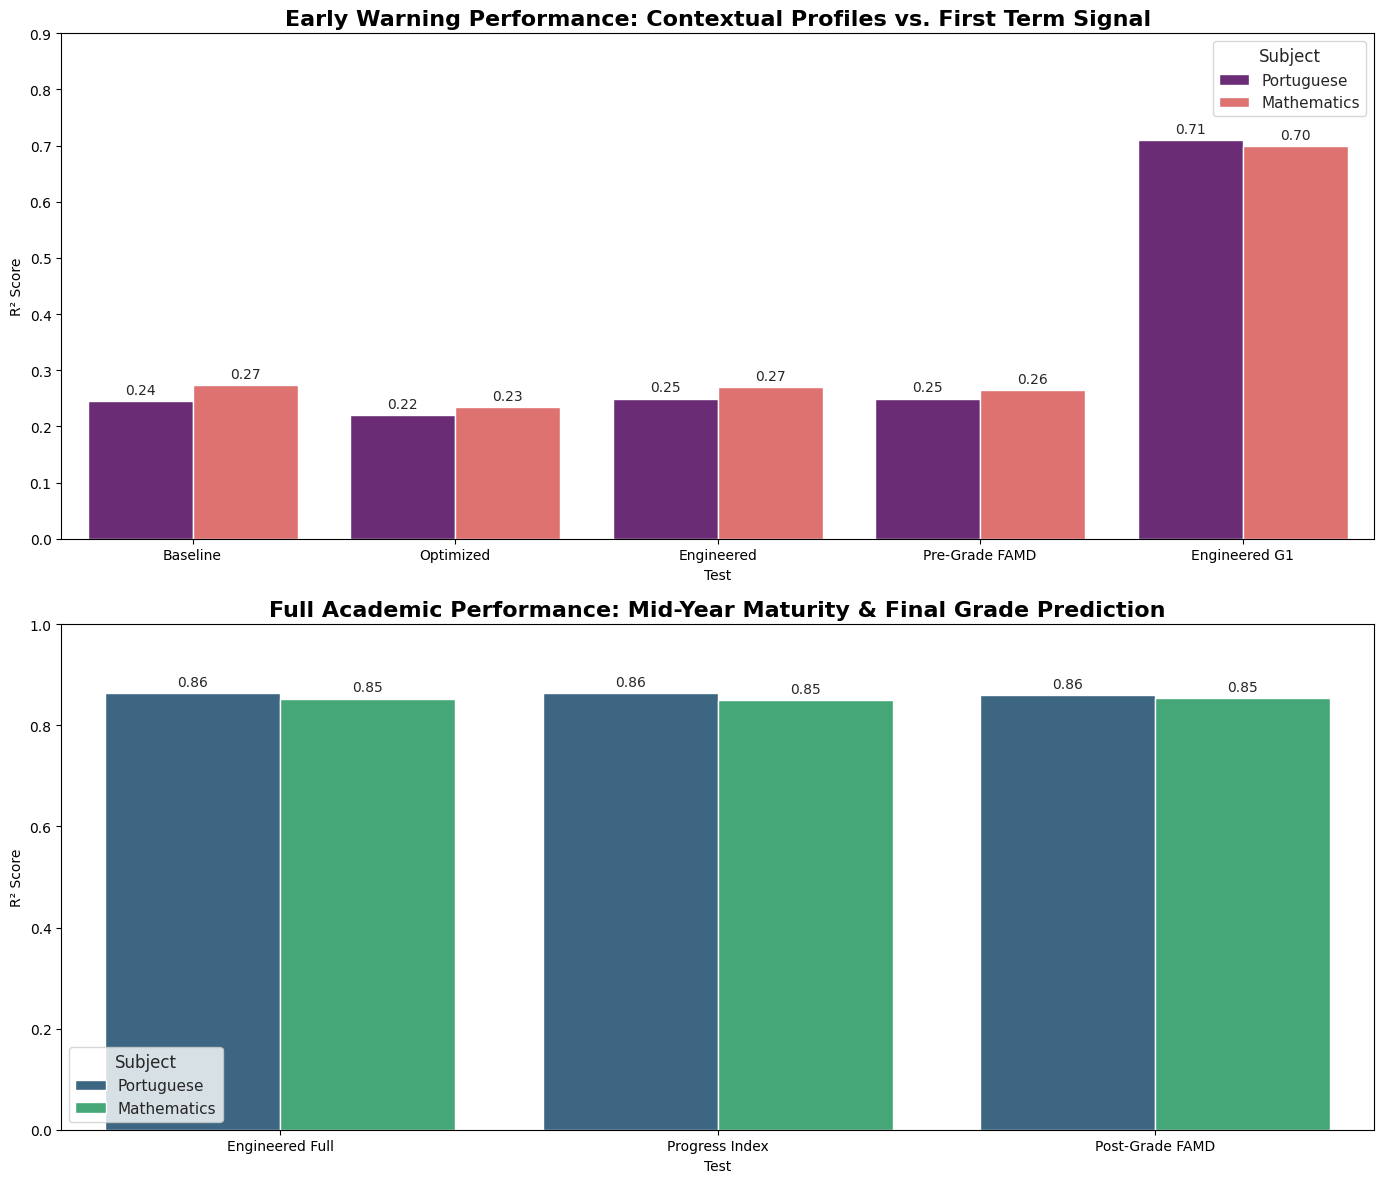

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Data structuring for progressive sensitivity analysis
data = [
#--- Portuguese ---
#Phase 1: Pre-Grades (Entry-level profile only)
{"Subject": "Portuguese", "Type": "Pre-Grades", "Test": "Baseline", "R2": 0.2449},
{"Subject": "Portuguese", "Type": "Pre-Grades", "Test": "Optimized", "R2": 0.2199},
{"Subject": "Portuguese", "Type": "Pre-Grades", "Test": "Engineered", "R2": 0.2497},
{"Subject": "Portuguese", "Type": "Pre-Grades", "Test": "Pre-Grade FAMD", "R2": 0.2497},
#Phase 2: Early Academic (G1 inclusion)
{"Subject": "Portuguese", "Type": "Early-Academic", "Test": "Engineered G1", "R2": 0.7102},
#Phase 3: Full Academic (G1 + G2 inclusion)
{"Subject": "Portuguese", "Type": "Post-Grades", "Test": "Engineered Full", "R2": 0.8644},
{"Subject": "Portuguese", "Type": "Post-Grades", "Test": "Progress Index", "R2": 0.8641},
{"Subject": "Portuguese", "Type": "Post-Grades", "Test": "Post-Grade FAMD", "R2": 0.8601},

#--- Mathematics ---
#Phase 1: Pre-Grades
{"Subject": "Mathematics", "Type": "Pre-Grades", "Test": "Baseline", "R2": 0.2730},
{"Subject": "Mathematics", "Type": "Pre-Grades", "Test": "Optimized", "R2": 0.2347},
{"Subject": "Mathematics", "Type": "Pre-Grades", "Test": "Engineered", "R2": 0.2695},
{"Subject": "Mathematics", "Type": "Pre-Grades", "Test": "Pre-Grade FAMD", "R2": 0.2647},
#Phase 2: Early Academic
{"Subject": "Mathematics", "Type": "Early-Academic", "Test": "Engineered G1", "R2": 0.6988},
#Phase 3: Full Academic
{"Subject": "Mathematics", "Type": "Post-Grades", "Test": "Engineered Full", "R2": 0.8532},
{"Subject": "Mathematics", "Type": "Post-Grades", "Test": "Progress Index", "R2": 0.8508},
{"Subject": "Mathematics", "Type": "Post-Grades", "Test": "Post-Grade FAMD", "R2": 0.8548}
]

df_all = pd.DataFrame(data)

#Plotting configuration
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))
sns.set_theme(style="whitegrid")

#Visualizing Early Warning potential (Contextual vs First Academic Signal)
early_df = df_all[df_all['Type'].isin(['Pre-Grades', 'Early-Academic'])]
sns.barplot(ax=ax1, data=early_df, x='Test', y='R2', hue='Subject', palette='magma')
ax1.set_title("Early Warning Performance: Contextual Profiles vs. First Term Signal", fontsize=16, fontweight='bold')
ax1.set_ylim(0, 0.9)
ax1.set_ylabel("R² Score")

#Value mapping for Ax1
for p in ax1.patches:
    if p.get_height() > 0:
        ax1.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', xytext=(0, 8), textcoords='offset points', fontsize=10)

#Visualizing Full Academic Certainty (Post-Grades momentum)
post_df = df_all[df_all['Type'] == 'Post-Grades']
sns.barplot(ax=ax2, data=post_df, x='Test', y='R2', hue='Subject', palette='viridis')
ax2.set_title("Full Academic Performance: Mid-Year Maturity & Final Grade Prediction", fontsize=16, fontweight='bold')
ax2.set_ylim(0, 1.0)
ax2.set_ylabel("R² Score")

#Value mapping for Ax2
for p in ax2.patches:
    if p.get_height() > 0:
        ax2.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', xytext=(0, 8), textcoords='offset points', fontsize=10)

plt.tight_layout()
plt.show()

Following the insights from the sensitivity analysis, the final refinement phase prioritizes operational efficiency and field-readiness for the post-grade stage. Since academic performance (G1/G2) tends to absorb the predictive signal of broader socio-demographic factors, the objective is to determine if high-level accuracy can be maintained using a significantly reduced set of core features.

By selecting only the most recurrent and influential predictors identified in previous trials, a streamlined 'minimalist' dataset will be constructed to simplify real-world data collection for educators.

In [13]:
from modeling.regression_trees import xgboost_regression
from modeling.advanced_models import svm_regression

#Define minimalist core features for field implementation
scenarios = {
    "portuguese": {
        "train": train_port,
        "test": test_port,
        "features": ['G2', 'G1', 'absences_log', 'school', 'failures']
    },
    "mathematics": {
        "train": train_math,
        "test": test_math,
        "features": ['G2', 'G1', 'absences_log', 'reason_home', 'age']
    }
}

#Execute cross-model benchmarking for parsimony validation
for subject, data in scenarios.items():
    print(f"\n" + "="*40)
    print(f"Analysis for: {subject.upper()}")
    print("="*40)
    
    #Check if linear stability holds with few features
    compare_regularized_models(data['train'], data['test'], 'G3', data['features'])
    
    #Compare against ensemble and kernel methods
    random_forest_regression(data['train'], data['test'], 'G3', data['features'])
    xgboost_regression(data['train'], data['test'], 'G3', data['features'])
    svm_regression(data['train'], data['test'], 'G3', data['features'])


Analysis for: PORTUGUESE
Starting Regularized Models Comparison...
Predictors: 5 | CV Folds: 5
-----------------------------------
--- Lasso Regression Summary ---
Best Alpha: 0.00098
R2 Score (Test): 0.8604 | Features: 5/5
-----------------------------------
--- Ridge Regression Summary ---
Best Alpha: 4.32876
R2 Score (Test): 0.8596
-----------------------------------
--- ElasticNet Regression Summary ---
Best Alpha: 0.00259 | Best L1: 0.50
R2 Score (Test): 0.8604 | Features: 5/5
-----------------------------------

--- Final Comparison Summary ---
                  R2       MAE      RMSE
Lasso       0.860391  0.229784  0.359640
ElasticNet  0.860383  0.229616  0.359650
Ridge       0.859611  0.229944  0.360644
-----------------------------------

Model Champion: Lasso
Top 5 Coefficients for Lasso (Sorted by impact):


,Feature,Coefficient
0,G2,0.767215
1,G1,0.150897
2,absences_log,0.048933
3,school,0.037382
4,failures,-0.029381


--- Random Forest Summary ---
Best Params: {'model__max_depth': 5, 'model__min_samples_split': 10, 'model__n_estimators': 200}
R2 Score (Train): 0.8969
R2 Score (Test): 0.8506
-----------------------------------
--- XGBoost Summary ---
Best Params: {'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__n_estimators': 100, 'model__subsample': 0.8}
R2 Score (Train): 0.8999
R2 Score (Test): 0.8360
-----------------------------------
--- SVM (SVR) Summary ---
Best Params: {'model__C': 1, 'model__epsilon': 0.1, 'model__kernel': 'rbf'}
R2 Score (Test): 0.8264
-----------------------------------


,Feature,Importance
0,G2,0.833128
1,G1,0.230694
2,absences_log,0.024124
4,failures,0.018415
3,school,0.015212



Analysis for: MATHEMATICS
Starting Regularized Models Comparison...
Predictors: 5 | CV Folds: 5
-----------------------------------
--- Lasso Regression Summary ---
Best Alpha: 0.00097
R2 Score (Test): 0.8021 | Features: 5/5
-----------------------------------
--- Ridge Regression Summary ---
Best Alpha: 0.00100
R2 Score (Test): 0.8019
-----------------------------------
--- ElasticNet Regression Summary ---
Best Alpha: 0.00097 | Best L1: 1.00
R2 Score (Test): 0.8021 | Features: 5/5
-----------------------------------

--- Final Comparison Summary ---
                  R2       MAE      RMSE
Lasso       0.802140  0.301227  0.439495
ElasticNet  0.802140  0.301227  0.439495
Ridge       0.801893  0.301829  0.439769
-----------------------------------

Model Champion: Lasso
Top 5 Coefficients for Lasso (Sorted by impact):


,Feature,Coefficient
0,G2,0.771058
2,absences_log,0.152691
1,G1,0.137525
4,age,-0.070702
3,reason_home,-0.051593


--- Random Forest Summary ---
Best Params: {'model__max_depth': 10, 'model__min_samples_split': 5, 'model__n_estimators': 100}
R2 Score (Train): 0.9731
R2 Score (Test): 0.8110
-----------------------------------
--- XGBoost Summary ---
Best Params: {'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__n_estimators': 200, 'model__subsample': 0.8}
R2 Score (Train): 0.9598
R2 Score (Test): 0.8335
-----------------------------------
--- SVM (SVR) Summary ---
Best Params: {'model__C': 10, 'model__epsilon': 0.01, 'model__kernel': 'rbf'}
R2 Score (Test): 0.8209
-----------------------------------


,Feature,Importance
0,G2,0.908956
1,G1,0.185189
2,absences_log,0.085897
4,age,0.015324
3,reason_home,0.000000


| Dataset     | Model                | Test R2 | Test MAE | Key Highlights                                                                  |
|-------------|----------------------|---------|----------|---------------------------------------------------------------------------------|
| Portuguese  | Lasso (Champion)     | 0.8604  | 0.2298   | Linear models outperform trees; high stability with 5 features.                |
|             | Random Forest        | 0.8506  | 0.2189   | Very close to linear performance; G2 is ultra-dominant (92%).                  |
|             | XGBoost              | 0.8360  | 0.2219   | Slightly underperforms; potential overfitting despite tuning.                  |
|             | SVM (SVR)            | 0.8264  | 0.2427   | Lowest performance; linear kernel preferred for this subject.                  |
|             |                      |         |          |                                                                                 |
| Mathematics | XGBoost (Champion)   | 0.8335  | 0.2399   | Non-linear model wins; captures complexities better than linear.               |
|             | SVM (SVR)            | 0.8176  | 0.2490   | Very strong performance; handles the "mathematics gap" well.                  |
|             | Random Forest        | 0.8110  | 0.2462   | Solid performance; balances G2 and absences effectively.                       |
|             | Lasso                | 0.8021  | 0.3012   | Lowest performance; linear logic is too rigid for math grades.                 |


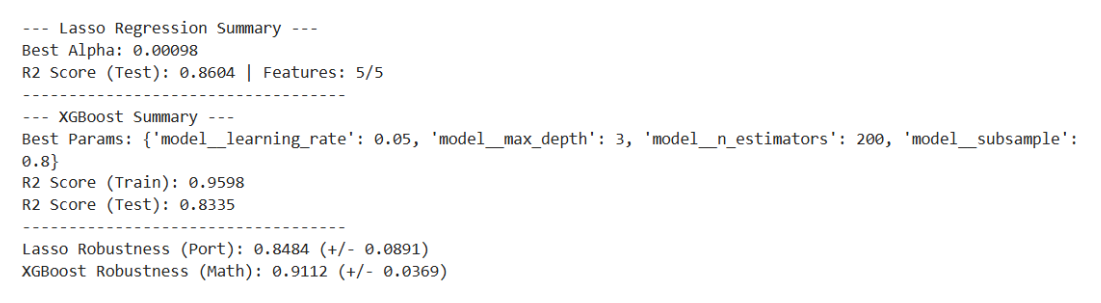

The final benchmarking phase demonstrates that predictive performance remains remarkably high even with a drastically reduced set of five features, confirming the viability of a parsimonious model for field implementation. 

To ensure these results were not due to a favorable data split, we performed 5-fold Cross-Validation (CV) to measure stability.

- **Portuguese Champion: Lasso Regression**: The Lasso model achieved a test $R^2$ of 0.8604 with a solid CV average of 0.8484 ($\pm 0.08$). This stability confirms that once academic momentum ($G1/G2$) is established, the relationship remains predominantly linear and highly predictable. The parsimonious approach retains almost all the predictive power of the full-feature model.

- **Mathematics Champion: XGBoost**: The Mathematics dataset benefits significantly from non-linear modeling, with XGBoost achieving an $R^2$ of 0.8335. Most notably, the CV robustness score reached 0.9112 with a very low variance ($\pm 0.03$), indicating a highly reliable generalization.

This suggests that while Portuguese grades follow a stable trajectory, Mathematics involves complex interactions—such as the "snowball effect" of absences on cumulative concepts—that ensemble methods capture with superior consistency.

**Quality Evaluation Conclusion**: These results prove that a simplified tool focusing on grades, absences, and school/age factors provides reliable warnings. The high CV Robustness scores across both subjects demonstrate that our parsimonious selection resists "overfitting" and is ready for real-world academic environments where data collection must be kept minimal.

## 3.8-Summary - Notebook 3

| Category              | Main Implementation            | Notes / Insights                                                                                                                                           |
|-----------------------|--------------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Initial Baselines     | Full Feature Set (Static)      | Established the predictive floor (R² ≈ 0.24 for Portuguese, 0.27 for Mathematics) without grades. Confirmed failures and higher as primary socio-demographic anchors. |
| Post-Grade Entry      | G1 & G2 Integration            | Massive performance leap (R² > 0.85). G2 becomes the dominant predictor, absorbing most contextual noise while absences_log remains a critical behavioral signal. |
| Baseline Optimization | Empirical Pruning              | Filtered weak learners (Mjob, Pstatus, etc.). Improved model stability for Portuguese post-grade but showed that pre-grade models rely on the collective signal of weak variables. |
| Model Specialization  | Linear vs. Non-Linear Logic    | Formalized a differentiated strategy: Regularized Linear Models for Portuguese (additive stability) and Random Forest for Mathematics (complex interactions). |
| Feature Intelligence  | Composite Indices              | Introduced Parental_Edu_Level and Alcohol_Index. Successfully consolidated correlated features into broader behavioral pillars without losing predictive power. |
| Academic Momentum     | Early Progress Index           | Added (G2 − G1) trajectory. Maintained high stability across both subjects ($R^2 \approx 0.85$), proving that mid-term velocity is a reliable predictor when balanced with behavioral anchors. |
| Advanced Reduction    | FAMD Implementation            | Applied Factorial Analysis of Mixed Data to reduce dimensionality to 5 components. Provided a mathematical benchmark against manual human-logic feature engineering. |
| Final Benchmarking    | Minimalist Parsimony           | Tested a 5-feature Core Nucleus. Lasso won for Portuguese (R² = 0.86) and XGBoost for Mathematics (R² = 0.83), proving high accuracy is possible with minimal data. |


## 3.9-Data Export

In [14]:
import pickle

#Define output filename
export_filename = "student_performance_modeling_final_bundle.pkl"

#Construct the bundle
final_export = {
    "data": {
        "portuguese": {
            "train": train_port,
            "test": test_port
        },
        "math": {
            "train": train_math,
            "test": test_math
        }
    },
    "features": {
        "portuguese_minimal": scenarios["portuguese"]["features"],
        "mathematics_minimal": scenarios["mathematics"]["features"],
        "famd_input_cols": famd_input_cols 
    },
    "reduction": {
        "famd_port": eigen_p,
        "famd_math": eigen_m 
    },
    "metadata": {
        "target": "G3",
        "author": "J-F Jutras",
        "date": "January 2026"
    }
}

#Save the bundle
with open(export_filename, "wb") as f:
    pickle.dump(final_export, f, protocol=pickle.HIGHEST_PROTOCOL)

print(f"--- Export Successful: {export_filename} ---")
print(f"Train/Test sets, Minimal features, and FAMD structures are locked.")

--- Export Successful: student_performance_modeling_final_bundle.pkl ---
Train/Test sets, Minimal features, and FAMD structures are locked.
